필요한 라이브러리 import 및 데이터 가져오기


In [46]:
!pip install konlpy

In [47]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import sys
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize


train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

데이터 진행 과정 확인을 위한 Progress Bar Util

In [48]:
def printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
    formatStr = "{0:." + str(decimals) + "f}"
    percent = formatStr.format(100 * (iteration / float(total)))
    filledLength = int(round(barLength * iteration / float(total)))
    bar = '#' * filledLength + '-' * (barLength - filledLength)
    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percent, '%', suffix)),
    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

훈련용 데이터 전처리

In [49]:
train_data.drop_duplicates(subset=['document'], inplace=True)                         # Sentence 열에서 중복인 내용이 있다면 중복 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
train_data['document'].replace('', np.nan, inplace=True)                              # 공백 Nan으로 대체
train_data = train_data.dropna(how = 'any')                                           # Nan 데이터 제거

total_length = len(train_data)

with open(r'kor_stopwords.txt',"r") as f:
    stopwords = f.readlines()

okt = Okt()

stopwords = [x.strip() for x in stopwords] 

number = 0
X_train = []
for sentence in train_data['document']:
    number += 1
    printProgress(number, total_length, 'Progress:', 'Complete', 1, 100)
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)                    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # stopword 제거
    X_train.append(temp_X)

Progress: |####################################################################################################| 100.0% Complete


테스트용 데이터 전처리

In [50]:
test_data.drop_duplicates(subset = ['document'], inplace=True)                      # Sentence 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True)                             # 공백 Nan으로 대체
test_data = test_data.dropna(how='any')                                             # Nan 데이터 제거

total_length = len(test_data)

with open(r'kor_stopwords.txt',"r") as f:
    stopwords = f.readlines()

okt = Okt()

stopwords = [x.strip() for x in stopwords] 

number = 0
X_test = []
for sentence in test_data['document']:
    number += 1
    printProgress(number, total_length, 'Progress:', 'Complete', 1, 100)
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)                    # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

Progress: |####################################################################################################| 100.0% Complete


In [68]:
len(test_data)

48995

정수 인코딩

In [51]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

print(tokenizer.word_index)

{'영화': 1, '보다': 2, '하다': 3, '도': 4, '는': 5, '은': 6, '없다': 7, '이다': 8, '좋다': 9, '너무': 10, '다': 11, '정말': 12, '한': 13, '되다': 14, '재밌다': 15, '적': 16, '만': 17, '진짜': 18, '아니다': 19, '않다': 20, '점': 21, '만들다': 22, '나오다': 23, '연기': 24, '평점': 25, '내': 26, '최고': 27, '안': 28, '인': 29, '스토리': 30, '생각': 31, '못': 32, '드라마': 33, '게': 34, '감동': 35, '사람': 36, '보고': 37, '이렇다': 38, '말': 39, '고': 40, '아깝다': 41, '더': 42, '배우': 43, 'ㅋㅋ': 44, '감독': 45, '거': 46, '그냥': 47, '재미있다': 48, '요': 49, '재미': 50, '내용': 51, '뭐': 52, '중': 53, '주다': 54, '자다': 55, '하고': 56, '지루하다': 57, '재미없다': 58, '쓰레기': 59, '수': 60, '모르다': 61, '가다': 62, '들다': 63, '그렇다': 64, '싶다': 65, '지': 66, '작품': 67, '사랑': 68, '알다': 69, '다시': 70, '마지막': 71, '볼': 72, '잘': 73, '이건': 74, '정도': 75, '완전': 76, '오다': 77, 'ㅋ': 78, 'ㅠㅠ': 79, '많다': 80, '처음': 81, 'ㅋㅋㅋ': 82, '장면': 83, '액션': 84, '주인공': 85, '이렇게': 86, '안되다': 87, '걸': 88, '차다': 89, '나다': 90, '개': 91, '최악': 92, '돈': 93, '이야기': 94, '지금': 95, '넘다': 96, '느낌': 97, '임': 98, '연출': 99, 'ㅡㅡ': 100, '라': 101, '인데

단어 분포 확인 (3회 미만의 단어)

In [52]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0                          # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                        # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                         # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43511
등장 빈도가 2번 이하인 희귀 단어의 수: 24308
단어 집합에서 희귀 단어의 비율: 55.8663326515134
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.946010337061098


빈도수가 적은 단어들 제거

In [53]:
# 전체 단어들 중 빈도수 2이하인 단어 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 + 2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19205


위에서 설정한 특정 단어 집합의 크기(빈도수 3이상만)로 토크나이징

In [54]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

label 값들 저장 후, 빈 샘플들 제거

In [55]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

print(len(X_train))
print(len(y_train))

145294
145294


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


서로 다른 길이의 샘플들의 길이를 동일하게 작업 (패딩)

리뷰의 최대 길이 : 71
리뷰의 평균 길이 : 10.573182650350324


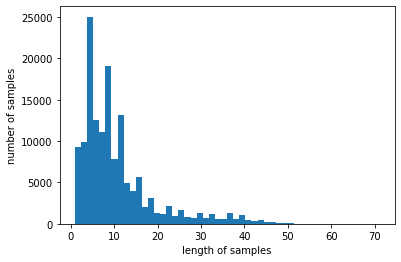

In [56]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수

In [57]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len 이하 샘플의 비율 확인

In [58]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.6164328877999


모든 샘플의 길이를 일정 값(max_len)으로 지정

In [59]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

LSTM으로 리뷰 감성 분류 시작

In [60]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1938/1938 [==============================] - 163s 83ms/step - loss: 0.4364 - acc: 0.7920 - val_loss: 0.3586 - val_acc: 0.8415

Epoch 00001: val_acc improved from -inf to 0.84149, saving model to best_model.h5
Epoch 2/15
1938/1938 [==============================] - 156s 81ms/step - loss: 0.3266 - acc: 0.8582 - val_loss: 0.3382 - val_acc: 0.8525

Epoch 00002: val_acc improved from 0.84149 to 0.85254, saving model to best_model.h5
Epoch 3/15
1938/1938 [==============================] - 155s 80ms/step - loss: 0.3008 - acc: 0.8722 - val_loss: 0.3295 - val_acc: 0.8560

Epoch 00003: val_acc improved from 0.85254 to 0.85598, saving model to best_model.h5
Epoch 4/15
1938/1938 [==============================] - 155s 80ms/step - loss: 0.2796 - acc: 0.8833 - val_loss: 0.3362 - val_acc: 0.8561

Epoch 00004: val_acc improved from 0.85598 to 0.85612, saving model to best_model.h5
Epoch 5/15
1938/1938 [==============================] - 158s 81ms/step - loss: 0.2637 - acc: 0.8906 - val_loss:

가장 좋은 모델을 기준으로 테스트 데이터 정확도 측정

In [61]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1532/1532 [==============================] - 18s 11ms/step - loss: 0.3502 - acc: 0.8519

 테스트 정확도: 0.8519


새로운 문장이 들어오면 긍정/부정인지 예측하는 함수

In [62]:
def sentiment_predict(new_sentence):
    with open(r'kor_stopwords.txt',"r") as f:
        stopwords = f.readlines()

    okt = Okt()

    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측

    if (score > 0.5):
        # print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
        return 1
    else:
        # print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
        return 0

Kaggle Sample 데이터를 통한 결과 분류 시작

In [63]:
predict_data = pd.read_csv('data.csv', encoding='CP949')
total_length = len(predict_data)

cols = ['Id', 'Predicted']
lst = []
for index, row in predict_data.iterrows():
    printProgress(row['Id'], total_length, 'Progress:', 'Complete', 1, 100)
    lst.append([row['Id'], sentiment_predict(row['Sentence'])])

result_df = pd.DataFrame(lst, columns=cols)
print(result_df)


Progress: |####################################################################################################| 100.0% Complete          Id  Predicted
0          0          1
1          1          0
2          2          0
3          3          1
4          4          0
...      ...        ...
11182  11182          1
11183  11183          0
11184  11184          1
11185  11185          1
11186  11186          0

[11187 rows x 2 columns]


분석된 결과를 CSV 파일로 export

In [66]:
result_df.to_csv('sample.csv', sep=',', index=False)